<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.materials import ACIConcrete, BilinearSteel
from assets.modules.steel import LongitudinalRebar, TransverseRebar
from assets.modules.shapes import *
from assets.modules.analysis import *
import assets.modules.concrete as concrete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.patches import bbox_artist
from Pynite import FEModel3D

## FIND STRAND PROFILE

Strand profile:
y = 0.2565x^2 + -2.2649x + 0.0000


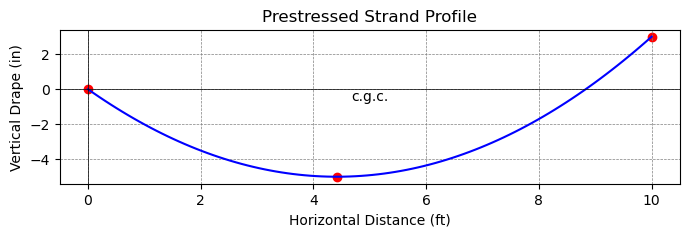

In [2]:
p0 = Point(0, 0)
p1 = Point(10, 3)
y_ext = -5

a, b, c = parabola_from_points(p0, p1, y_ext)

print(f"Strand profile:\ny = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

x_ext = -b / (2 * a)
y_ext_calc = a * x_ext**2 + b * x_ext + c

x_vals = np.linspace(min(p0.x, p1.x), max(p0.x, p1.x), 100)
y_vals = a * x_vals**2 + b * x_vals + c

plt.figure(figsize=(8, 2))
plt.plot(x_vals, y_vals, label='Parabolic Strand Profile', color='blue')
plt.scatter([p0.x, p1.x, x_ext], [p0.y, p1.y, y_ext_calc], color='red')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.text((p0.x + p1.x)/2, p0.y, "c.g.c.", fontsize=10, va='top', ha='center')
plt.xlabel('Horizontal Distance (ft)')
plt.ylabel('Vertical Drape (in)')
plt.title('Prestressed Strand Profile')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

## Define Beams, columns, and Joints

In [3]:
concrete = ACIConcrete(fc=5000, is_lightweight=False, density=150 / 12**3)

n_spans = 2

# Define lower and upper columns
lower_cols, upper_cols = [], []
for i in range(n_spans + 1):
    lower_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=concrete))
    upper_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=concrete))

# Define beams
beam_lengths = [62, 44]
beams: list[ConcreteTSectionBeam] = []
for length in beam_lengths:
    beams.append(ConcreteTSectionBeam(length=length, width=15/12, depth=36/12, flange_width=95/12, flange_thickness=5/12, mat=concrete))

# Define joints
joints = []
for i in range(n_spans + 1):
    left_beam = None if i == 0 else beams[i-1]
    right_beam = None if i == n_spans else beams[i]
    joints.append(Concrete2DJoint(left_beam, right_beam, lower_cols[i], upper_cols[i]))
    
print("Defined Columns:")
for col in lower_cols + upper_cols:
    print(col)
    
print("\nDefined Beams:")
for beam in beams:
    print(beam)
    
print("\nDefined Joints:")
for joint in joints:
    print(joint)


Defined Columns:
Column C1 @ J1 [height=11.33', 24.0" x 24.0"]
Column C3 @ J2 [height=11.33', 24.0" x 24.0"]
Column C5 @ J3 [height=11.33', 24.0" x 24.0"]
Column C2 @ J1 [height=11.33', 24.0" x 24.0"]
Column C4 @ J2 [height=11.33', 24.0" x 24.0"]
Column C6 @ J3 [height=11.33', 24.0" x 24.0"]

Defined Beams:
T-Beam B1 @ J1 --> J2 [length=62.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]
T-Beam B2 @ J2 --> J3 [length=44.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]

Defined Joints:
2D Joint J1 @ None← →B1, C1↓ ↑C2
2D Joint J2 @ B1← →B2, C3↓ ↑C4
2D Joint J3 @ B2← →None, C5↓ ↑C6


## Compute Beam Section Properties

Both spans have the same section.

In [4]:
# Beam section properties

# Beam area
A = beams[0].sec.area * 12**2 # ft^2
print(f"A={A:.0f} in^2")

# Beam moment of inertia
I = beams[0].sec.moment_inertia()[0] * 12**4 # in^4
print(f"I={I:.0f} in^4")

# Beam centroid relait veo the top and bottom and top of the beam
yt = beams[0].sec.yt * 12 # in
yb =  beams[0].sec.yb * 12 # in
print(f"yt={yt:.1f} in")
print(f"yb={yb:.1f} in")

# Beam section modulus
S_t = I / yt # in^3
S_b = I / yb # in^3
print(f"St={S_t:.0f} in^3")
print(f"Sb={S_b:.0f} in^3")

A=940 in^2
I=114360 in^4
yt=11.4 in
yb=24.6 in
St=10028 in^3
Sb=4650 in^3


## Define Loads

* Both spans have the same 15"x36" beam cast monolitically with the slab creating a T-section.
* Beams are repated @ 18-ft o.c.
* For the live load assume standard parking loading

In [5]:
# Compute area loads
concrete_density = concrete.density * (12**3/1e3) # k/ft^3

slab_thickness = 5/12 # ft
slab_load = slab_thickness *  concrete_density# k/ft^2

beam_spacing = 18 # ft
beam_sec: ConcreteTSectionBeam = beams[0]
beam_load = (beam_sec.depth - slab_thickness) * beam_sec.width * concrete_density / beam_spacing # k/ft^2

superimposed_dead_load = 2 / 1e3 # k/ft^2

concrete_load = slab_load + beam_load # k/ft^2
dead_load = concrete_load + superimposed_dead_load # k/ft^2
live_load = 40 / 1e3 # k/ft^2

print(f"Concrete load: {concrete_load:.3f} k/ft^2")
print(f"Dead load: {dead_load:.3f} k/ft^2")
print(f"Live load: {live_load:.3f} k/ft^2\n")

# Compute beam loads
w_conc = concrete_load * beam_spacing # k/ft
w_dead = dead_load * beam_spacing # k/ft
w_live = live_load * beam_spacing # k/ft

print(f"w_conc = {w_conc:.3f} k/ft")
print(f"w_dead = {w_dead:.3f} k/ft")
print(f"w_live = {w_live:.3f} k/ft\n")

# Compute factored loads
w_ud = 1.2 * w_dead # k/ft
w_ul = 1.6 * w_live # k/ft
w_u = w_ud + w_ul # k/ft

print(f"w_ud = {w_ud:.3f} k/ft")
print(f"w_ul = {w_ul:.3f} k/ft")
print(f"w_u = {w_u:.3f} k/ft\n")


Concrete load: 0.089 k/ft^2
Dead load: 0.091 k/ft^2
Live load: 0.040 k/ft^2

w_conc = 1.609 k/ft
w_dead = 1.645 k/ft
w_live = 0.720 k/ft

w_ud = 1.974 k/ft
w_ul = 1.152 k/ft
w_u = 3.126 k/ft



## Compute Prestressing Force

Balacing approximately 70% of concrete load in each span and proviing a minimum of 250 psi average prestressing compression.


In [6]:
min_comp_stress = 250 /1e3 # ksi
balance_factor = 0.7

# Beam: A-----B-----C
# Center of gravity of strand profile (c.g.s.) from the top of the beam
cgs_a = yt # in
cgs_ab = beam_sec.depth * 12 - 4 # in
cgs_b = 4 # in

# Compute prestressing force to balance 70% of concrete load
l_ab = beams[0].length # ft
ecc_ab = cgs_ab - (cgs_a + cgs_b) / 2 # in
w_eq_ab = balance_factor * w_conc
F_min = min_comp_stress * (beams[0].sec.area * 12**2) # kips
F = max(F_min, (w_eq_ab * l_ab**2 / 8) / (ecc_ab / 12)) # kips
print(f"a={ecc_ab:.1f} in")
print(f"F={F:.0f} kips ≥ Fmin={F_min:.0f} kips\n")

a=24.3 in
F=267 kips ≥ Fmin=235 kips



## Compute Number of Strands

* Assume 1/2"-strands with the area of 0.153 in² and $f_{pu}=270\ ksi$.
* Assume $15\ ksi$ prestressing loss.

In [7]:
strand_area = 0.153 # in^2
fpu = 270 # ksi
prestressing_loss = 15 # ksi
fpe = 0.7 * fpu - prestressing_loss # ksi

# Compute number of required strands
n_strands = F / (strand_area * fpe)
n_strands = int(np.floor(n_strands))
Aps = n_strands * strand_area # in^2
F = n_strands * strand_area * fpe # kips
print(f"Number of 1/2\"-strands: {n_strands} (Aps={Aps:.3f} in^2)")
print(f"Provided prestressing force: F={F:.0f} kips")


Number of 1/2"-strands: 10 (Aps=1.530 in^2)
Provided prestressing force: F=266 kips


## Compute Drape in Shorter Span

Using the prestressing force and number of strands determined in the previous section, I calculate the drape in the middle of the second span to balance 70% of the concrete load.

In [8]:
# Beam: A-----B-----C
l_bc = beams[1].length # ft
ecc_bc = (w_eq_ab * l_bc**2 / 8) / F * 12 # in
cgs_c = yt  # in
cgs_bc = ecc_bc + (cgs_b + cgs_c) / 2 # in
print(f"a={beams[0].depth * 12 - cgs_bc:.1f} in (from the bottom of the beam)")

a=16.0 in (from the bottom of the beam)


## Determine Actual Prestressing Equivalent Loads

In [9]:
w_eq_ab = -8 * F * (ecc_ab / 12) / (l_ab**2) # k/ft, upward negative
w_eq_bc = -8 * F * (ecc_bc / 12) / (l_bc**2) # k/ft, upward negative

print(f"{'Span':<7}{'w_eq (klf)':<16}{'a (in)':<10}{'mid-span drape (in)':<15}")
print(f"{'-'*7:<7}{'-'*15:<15}{'-'*15:<15}{'-'*15:<15}")
print(f"{'AB':<7}{w_eq_ab:.3f} ({100*abs(w_eq_ab/w_conc):.1f}{'%)':<5}{ecc_ab:<10.3f}{beams[0].depth * 12 - cgs_ab:<15.3f}")
print(f"{'BC':<7}{w_eq_bc:.3f} ({100*abs(w_eq_bc/w_conc):.1f}{'%)':<5}{ecc_bc:<10.3f}{beams[1].depth * 12 - cgs_bc:<15.3f}")

Span   w_eq (klf)      a (in)    mid-span drape (in)
----------------------------------------------------
AB     -1.122 (69.7%)   24.298    4.000          
BC     -1.127 (70.0%)   12.289    16.009         


## Compute Distribution Factors, Carry-Over Factors, and Fixed-End Moments

In [10]:
import pandas as pd

# Build DataFrame with joint + element association
df = pd.DataFrame({
    "Joint ID": [j.id for j in joints for e in j._elements],
    "Element ID": [e.id for j in joints for e in j._elements],
    "Stiffness": [j.stiffness_factors[e.id] for j in joints for e in j._elements],
    "Distribution": [j.distribution_factors[e.id] for j in joints for e in j._elements],
    "Carry-Over": [j.carry_over_factors[e.id] for j in joints for e in j._elements]
})

# Group by Joint ID
grouped = df.groupby("Joint ID")

for joint_id, group in grouped:
    print(f"\nJoint {joint_id}")
    print(group)


# grouped_df = grouped.apply(lambda g: g).drop("Joint ID", axis=1)



Joint J1
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
0       J1         B1  224239.964792      0.189091    0.524187
1       J1         C2  480820.475546      0.405454    0.477149
2       J1         C1  480820.475546      0.405454    0.477149

Joint J2
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
3       J2         B1  224239.964792      0.148207    0.524187
4       J2         B2  327139.638317      0.216216    0.534073
5       J2         C4  480820.475546      0.317788    0.477149
6       J2         C3  480820.475546      0.317788    0.477149

Joint J3
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
7       J3         B2  327139.638317      0.253837    0.534073
8       J3         C6  480820.475546      0.373082    0.477149
9       J3         C5  480820.475546      0.373082    0.477149


## Fixed-End Moments

In [11]:
# Compute fixed-end moments for each beam under dead, live, and equivalent prestressing loads
loads = {
    "Dead": [w_dead, w_dead],
    "Live": [w_live, w_live],
    "Equivalent": [w_eq_ab, w_eq_bc]
}

FEM = {}
for i, beam in enumerate(beams):
    for load_name, load_value in loads.items():
        M_A, M_B = get_fixed_end_moment_uniform_load(
            uniform_load=load_value[i],
            length=beam.length,
            left_rigid_length=beam.start_rigid_length,
            right_rigid_length=beam.end_rigid_length
        )
        FEM[(beam.id, load_name)] = (M_A, M_B)
        
fem_df = pd.DataFrame.from_dict(
    FEM, 
    orient='index', 
    columns=['FEM_left (k-ft)', 'FEM_right (k-ft)']
)

fem_df


,FEM_left (k-ft),FEM_right (k-ft)
"(B1, Dead)",543.796438,-543.796438
"(B1, Live)",237.960000,-237.960000
"(B1, Equivalent)",-370.770994,370.770994
"(B2, Dead)",277.245688,-277.245688
"(B2, Live)",121.320000,-121.320000
"(B2, Equivalent)",-189.825781,189.825781


## Service Loads Shears and Moments

In [12]:
# Define uniform loads for each load case, units in k/ft, downward positive
uniform_loads = {
    "Dead":{"B1": w_dead, "B2": w_dead},
    "Live":{"B1": w_live, "B2": w_live},
    "Equivalent":{"B1": w_eq_ab, "B2": w_eq_bc}
}

# Beam end moments obtained from moment distribution analysis
# Units in k-ft, ccw positive, (M_left, M_right)
end_moments = {
    "Dead": {"B1": (459.2, -556.9), "B2": (372.7, -182.0)},
    "Live": {"B1": (201.0, -243.7), "B2": (163.1, -79.7)},
    "Equivalent": {"B1": (-313.1, 380.0), "B2": (-255.1, 125.0)}
}

N_POINTS = 15
n_beams = len(beams)
load_cases = list(uniform_loads.keys())

# Collect per-beam arrays in lists first
X_rows = [None] * n_beams
V = {lc: [None] * n_beams for lc in load_cases}
M = {lc: [None] * n_beams for lc in load_cases}

for j, beam in enumerate(beams):
    for i, lc in enumerate(load_cases):
        x, v, m = generate_shear_moment_diagrams(
            beam,
            uniform_loads[lc][beam.id],
            end_moments[lc][beam.id],
            n_points=N_POINTS,
        )
        V[lc][j] = v
        M[lc][j] = m
        if i == 0:               # x is the same across load cases for this beam
            X_rows[j] = x

# Stack into (n_beams, N_POINTS+1)
X = np.stack(X_rows, axis=0)
for lc in load_cases:
    V[lc] = np.stack(V[lc], axis=0)
    M[lc] = np.stack(M[lc], axis=0)

        
    

In [13]:
def plot_moment_shear_diagrams(beams, x, y: dict[str, list[np.ndarray]],**kwargs):
    figsize = kwargs.get('figsize', (10, 4))
    title = kwargs.get('title')
    
    # Find the index of zero shear (inflection point) for each beam
    inf_idx = np.empty((len(beams),), dtype=object)
    for i in range(len(beams)):
        inf_idx[i] = np.argmin(np.abs(list(y.values())[0]))

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    for idx, ax in enumerate(axes):
        y_val = list(y.values())[idx]
        y_label = list(y.keys())[idx]
        shift = 0
        
        for i, beam in enumerate(beams):
            
            ax.vlines(x=x[i][0] + shift, ymin=y_val[i-1][-1] if i>0 else 0, ymax=y_val[i][0], color='blue')
            ax.plot(x[i] + shift, y_val[i], color='blue')
            ax.vlines(x=x[i][-1] + shift, ymin=y_val[i][-1], ymax=y_val[i+1][0] if i<len(beams)-1 else 0, color='blue')
            
            ax.annotate(f"{y_val[i][0]:.1f}", xy=(x[i][0] + shift, y_val[i][0]), xytext=(x[i][0] + shift - 1, y_val[i][0] + 5),fontsize=9, color='red')
            ax.annotate(f"{y_val[i][-1]:.1f}", xy=(x[i][-1] + shift, y_val[i][-1]), xytext=(x[i][-1] + shift - 1, y_val[i][-1] + 5),fontsize=9, color='red')
            
            if inf_idx[i] and idx == len(axes) - 1:  # Moment diagram
                ax.annotate(f"{y_val[i][inf_idx[i]]:.1f}", xy=(x[i][inf_idx[i]] + shift, y_val[i][inf_idx[i]]), xytext=(x[i][inf_idx[i]] + shift + 1, y_val[i][inf_idx[i]] - 10), fontsize=9, color='red')
            
            shift += beam.length
            
        ax.set_ylabel(y_label)
        ax.axhline(0, color='black',linewidth=0.5)
        ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        
        if idx == len(axes) - 1:  # Moment diagram
            ax.invert_yaxis()
            ax.set_xlabel('Distance along beam (ft)')
        
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


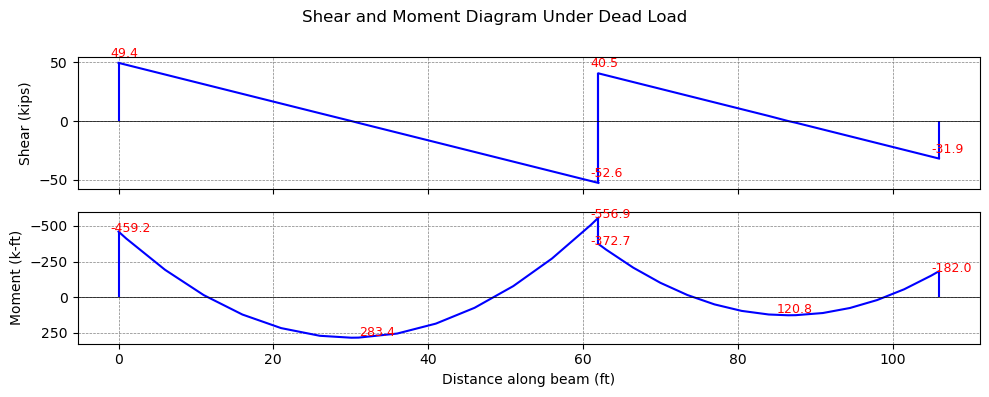

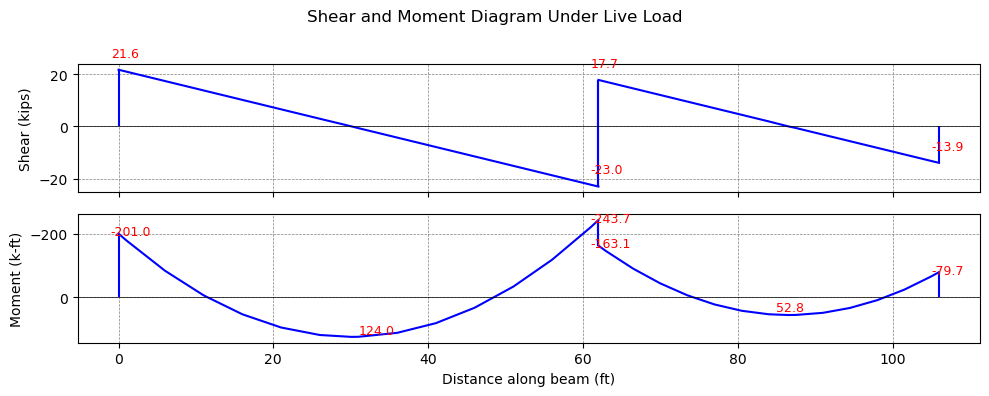

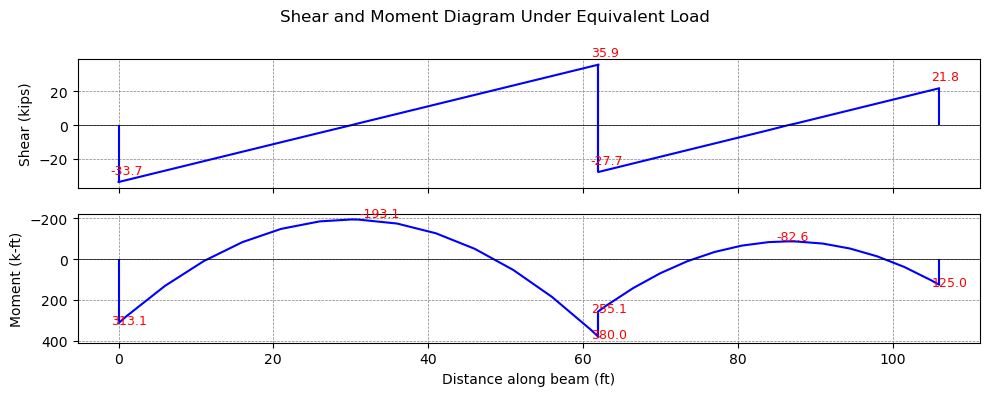

In [14]:
for load_case in uniform_loads.keys():
    plot_moment_shear_diagrams(
        beams, 
        X, {'Shear (kips)': V[load_case], 'Moment (k-ft)': M[load_case]}, 
        figsize=(10, 4), 
        title=f"Shear and Moment Diagram Under {load_case} Load")

In [15]:
# Concatenate results for all beams
dist_segments = []
shear, moment = {}, {}

for load_case in uniform_loads:
    # stack along beam axis first, then flatten
    shear[load_case] = np.hstack(V[load_case])
    moment[load_case] = np.hstack(M[load_case])

# build distance array with offsets
for i, beam in enumerate(beams):
    offset = sum(beam_lengths[:i])
    dist_segments.append(X[i] + offset)

dist = np.hstack(dist_segments)


# Create a dataframe to store x_coord, shear and moment for each load case
shear_moment_df = pd.DataFrame({
    "X (ft)": dist,
    "V_d (kips)": shear["Dead"],
    "M_d (k.ft)": moment["Dead"],
    "V_l (kips)": shear["Live"],
    "M_l (k.ft)": moment["Live"],
    "V_eql (kips)": shear["Equivalent"],
    "M_eql (k.ft)": moment["Equivalent"]
}).set_index("X (ft)")

shear_moment_df["V_s (kips)"] = shear_moment_df["V_d (kips)"] + shear_moment_df["V_l (kips)"] + shear_moment_df["V_eql (kips)"]
shear_moment_df["M_s (k.ft)"] = shear_moment_df["M_d (k.ft)"] + shear_moment_df["M_l (k.ft)"] + shear_moment_df["M_eql (k.ft)"]

# Set the dataframe to show all rows
pd.set_option('display.max_rows', None)
shear_moment_df

,V_d (kips),M_d (k.ft),V_l (kips),M_l (k.ft),V_eql (kips),M_eql (k.ft),V_s (kips),M_s (k.ft)
X (ft),,,,,,,,
0.000000,49.430819,-459.200000,21.631290,-201.000000,-33.698277,313.100000,37.363832,-347.100000
1.000000,47.785444,-410.591869,20.911290,-179.728710,-32.576429,279.962647,36.120305,-310.357932
6.000000,39.558569,-192.231839,17.311290,-84.172258,-26.967185,131.103613,29.902674,-145.300484
11.000000,31.331694,-15.006183,13.711290,-6.615806,-21.357942,10.290796,23.685042,-11.331194
16.000000,23.104819,121.085097,10.111290,52.940645,-15.748698,-82.475804,17.467411,91.549938
21.000000,14.877944,216.042002,6.511290,94.497097,-10.139455,-147.196186,11.249779,163.342913
26.000000,6.651069,269.864532,2.911290,118.053548,-4.530211,-183.870350,5.032148,204.047730
30.073175,0.000000,283.410017,0.000000,123.984305,0.000000,-193.087502,0.000000,214.306820
31.000000,-1.575806,282.679769,-0.688710,123.665541,1.079032,-192.585317,-1.185484,213.759993


## Service Stress

In [51]:
# Allowable tensile stress at service per ACI 318-25 table 24.5.2.1 (uncracked, class U)
f_ta = 7.5 * np.sqrt(concrete.fc) / 1000 # ksi

# Allowable compressive stress at service per ACI 318-25 table 24.5.4.1
f_ca = -0.6 * concrete.fc / 1000 # ksi

print(f"Allowable tensile stress at service, f_ta = {f_ta:.3f} ksi")
print(f"Allowable compressive stress at service, f_ca = {f_ca:.3f} ksi\n")

service_shear = np.zeros_like(X, dtype=float)
service_moment = np.zeros_like(X, dtype=float)

for load_case in ["Dead", "Live", "Equivalent"]:
    service_shear += V[load_case]
    service_moment += M[load_case]

service_stress_top  = np.zeros_like(X, dtype=float)
service_stress_bot  = np.zeros_like(X, dtype=float)

for i, beam in enumerate(beams):
    print(f"{beam.id}: A={beam.sec.area:.3f} ft2, St={beam.sec.section_modulus()['top']:.3f} ft3, Sb={beam.sec.section_modulus()['bottom']:.3f} ft3")
    
    selected_idx = [1, np.argmin(np.abs(service_shear[i])), -2]
    
    service_stress_top[i] = (-service_moment[i] / beam.sec.section_modulus()['top'] - F / beam.sec.area) / 12**2  # convert ksf to ksi
    
    service_stress_bot[i] = (service_moment[i] / beam.sec.section_modulus()['bottom'] - F / beam.sec.area) / 12**2  # convert ksf to ksi

M_s = service_moment[:, selected_idx].flatten()
sigma_st = service_stress_top[:, selected_idx].flatten()
sigma_sb = service_stress_bot[:, selected_idx].flatten()

print(f"\nService moment (k-ft):\t\t{M_s.round(1)}")
print(f"Service stress at top (ksi):\t{sigma_st.round(3)}")
print(f"Service stress at bottom (ksi):\t{sigma_sb.round(3)}")

Allowable tensile stress at service, f_ta = 0.530 ksi
Allowable compressive stress at service, f_ca = -3.000 ksi

B1: A=6.528 ft2, St=5.803 ft3, Sb=2.691 ft3
B2: A=6.528 ft2, St=5.803 ft3, Sb=2.691 ft3

Service moment (k-ft):		[-310.4  213.8 -381.4 -250.8   95.2 -113.6]
Service stress at top (ksi):	[ 0.088 -0.539  0.173  0.017 -0.397 -0.147]
Service stress at bottom (ksi):	[-1.084  0.268 -1.268 -0.93  -0.037 -0.576]
